# Single Cell apoptosis

As decribed in [Monier et al. 2015](http://www.nature.com/nature/journal/v518/n7538/full/nature14152.html).

We start with a simple hexagonal apical mesh with cylindrical symmetry. 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet
from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.stores import load_datasets

/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc1-py3.6.egg/tyssue/core/generation.py:3: UserWarning: generation should not be imported from core anymore but from its own module
  warnings.warn('generation should not be imported from core anymore but from its own module')


### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [2]:
# Read pre-recorded datasets
h5store = 'small_hexagonal.hf5'
datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
# Corresponding specifications
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

# Model
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc1-py3.6.egg/tyssue/stores/__init__.py:20: UserWarning: 
    This will soon be deprecated, use the leaner
    `tyssue.stores.stores_dir and tyssue.stores.stores_list
    
  """
/home/guillaume/miniconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc1-py3.6.egg/tyssue/dynamics/factory.py:55: UserWarning: This badly worded method is deprecated,
 use dimensionalize instead
  use dimensionalize instead''')


### First energy minimization

In [11]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


### Custom display function

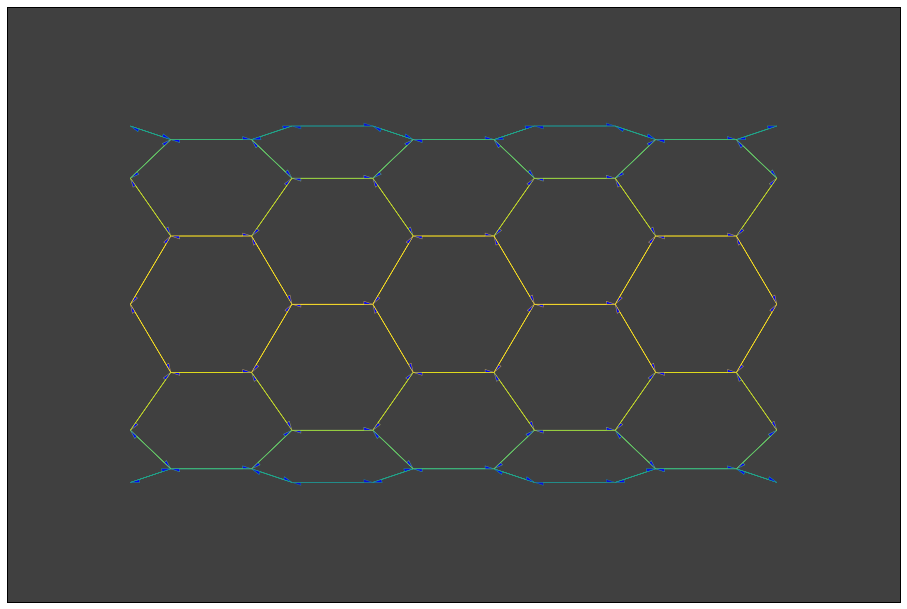

In [5]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-10, 10)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((16, 19))
    return fig, ax

fig, ax = leg_joint_view(sheet)


### Choosing an apoptotic cell 

In [6]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -2.175186
y    5.251365
z   -4.072821
Name: 16, dtype: float64
Indices of the apoptotic vertices: [28 39 29 38 40 41]


Sequences of events are defined in `time_tables` that describe the changes in the relevant cells at each time point.
I'm not very happy with the design of that piece, it looks a bit cluttered.

In [7]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
events = SheetEvents(sheet, model, geom).events

print('Defined events (single time step):')
print('\n'.join([k for k in events]))


Defined events (single time step):
divide
type1_at_shorter
contract
type3
shrink
ab_pull
grow


### Settings for the apoptotic cell 

In [8]:
sheet.settings['apoptosis'] = {
    'shrink_steps': 20,
    'rad_tension': 0.5,
    'contractile_increase': 1,
    'contract_span': 2
    }

times, time_table = apoptosis_time_table(sheet,
                                         apoptotic_cell,
                                         events,
                                         start_t=0)

The `time_table` is a `DataFrame` with a `(t, face) MultiIndex`. 

In [9]:
time_table.tail(20)

ab_pull contract divide grow  shrink type1_at_shorter type3
t  face                                                            
19 9        NaN      0.1    NaN  NaN     NaN              NaN   NaN
   10       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   11       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   14       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   15       NaN      0.1    NaN  NaN     NaN              NaN   NaN
   16      0.05      NaN    NaN  NaN  0.0001              NaN   NaN
   17       NaN      0.1    NaN  NaN     NaN              NaN   NaN
   18       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   21       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   22       NaN      0.1    NaN  NaN     NaN              NaN   NaN
   23       NaN      0.1    NaN  NaN     NaN              NaN   NaN
   24       NaN      0.1    NaN  NaN     NaN              NaN   NaN
   25       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   29       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   30       NaN     0.05    NaN  NaN     NaN              NaN   NaN
   31       NaN     0.05    NaN  NaN     NaN              NaN   NaN
20 16       NaN      NaN    NaN  NaN     NaN                1   NaN
21 16       NaN      NaN    NaN  NaN     NaN                1   NaN
22 16       NaN      NaN    NaN  NaN     NaN                1   NaN
23 16       NaN      NaN    NaN  NaN     NaN              NaN     1

We perform the events at each time points to run the simulation

In [12]:
for t in times:
    face_events = time_table.loc[t]
    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events[event_name](face, event_arg)

    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('single_apopto_{:03d}.png'.format(t))
    plt.close(fig)

Provided you have ImageMagick installed, we can convert the output to a nice gif, like so:

In [23]:
%%bash
convert -delay 1000 single_apopto*.png single_apopto.gif
rm single_apopto*.png

![Gif of the resulting simulation](single_apopto.gif)

### 3D view with vispy

In [22]:
canvas, view = vp_view(sheet, coords=['z', 'x', 'y'])

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
